<a href="https://colab.research.google.com/github/HectorRPabon/Colab/blob/main/WaPORp2_Cauca_AvAnnual_AETI_NPP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Using Python Libraries for Handling WaPOR Data**

Base on Notebook 3: Calculating areal average values using WaPOR data
In this Notebook we will show you how to calculate seasonal AETI and dekadal timeseries of AETI for different farms or group of farms (eg tertiary unit).   

The steps are:
1. Install and load necessary Python Libraries to manage raster files
2. Load and visualise seasonal WaPOR AETI created in [Notebook 2 : Temporal data aggregation](https://github.com/wateraccounting/WaPORMOOC/blob/main/3_Python_for_WaPOR/N02_Temporal_Aggregation.ipynb)
3. Calculate average seasonal AETI for each farm and calculate statistics
4. Calculate zonal statistics for tertiary unit
5. Visualise time series of dekadal AETI per municipality

* Seasonal WaPOR AETI tiff file created in [WaPORp2 Cauca - AETI / NPP Temporal data aggregation]

* For the Municipal level analyses we will be using the Municipio_Cauca.shp

 © 2024 IHE Delft Licenced under CC BY SA Creative Commons



---



### **Step 1 Install and import required python libraries**

In [ ]:
# Install required packages
%%capture
!pip install --upgrade xarray  --quiet
!pip install --upgrade geopandas --quiet
!pip install --upgrade rioxarray --quiet
!pip install rasterstats --quiet

In [ ]:
# Import the required packages
from osgeo import gdal
import xarray as xr
import rioxarray as rioxr
import numpy as np
import pandas as pd
import geopandas as gpd
import glob
import os
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
import matplotlib.colors as mcolors

### **N.B.**
>In this notebook we used additional Python Libraries called <font color='steelblue'>**`Xarray`**</font> and <font color='steelblue'>**`rioxarray`**</font>. <font color='steelblue'>**`Xarray`**</font> is a python library which simplifies working with labelled ulti-dimension arrays such as stack of rasters and<font color='steelblue'>**`rioxarray`**</font> is an Xarray extension that allows reading and writing a wide variety of geospatial image formats compatible with Geographic Information Systems (GIS). Introducing these libraries is out of the scope of this Notebook, but for **[xarray](https://tutorial.xarray.dev/overview/xarray-in-45-min.html)** and **[rioxarray](https://corteva.github.io/rioxarray/html/getting_started/getting_started.html)** you can find good Notebooks that provide a good introduction about the libraries for a basic understanding.



---



## **Step 2 - Load and visualise Annuall WaPOR AETI / NPP**

Execute the command below, click the `Choose Files` button, navigate to where you have saved the .tif file in your local drive and select the file.

In [ ]:
#To upload file.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The following script displays the data read using 'rioxarray' and plotted using the `matplotlib` Libary

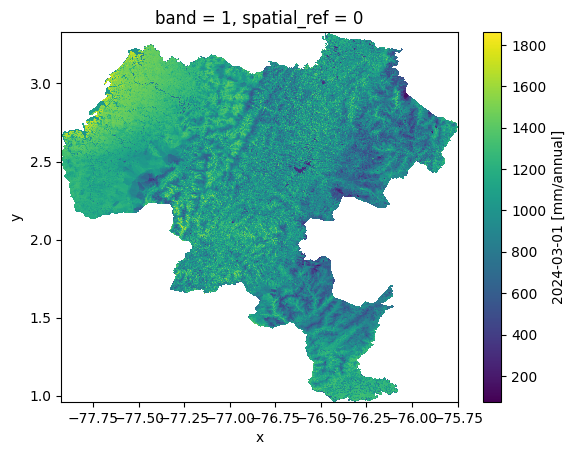

In [ ]:
anual_AETI = '/content/drive/MyDrive/Data/Cauca/Cauca_AETI2024.tif'      # Path to seasonal file
anual = rioxr.open_rasterio(anual_AETI)             # open the raster file
anual.plot()                                         # Display the raster file

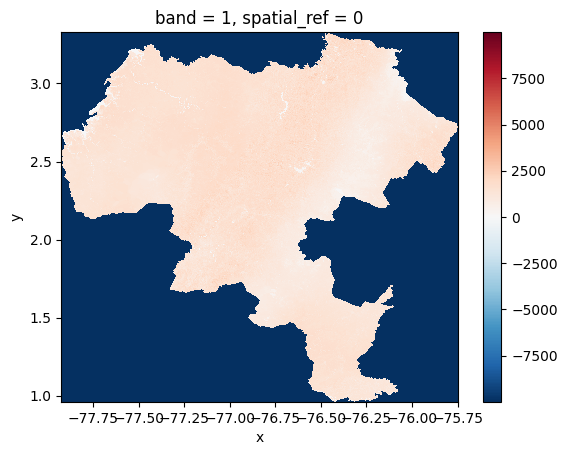

In [28]:
anual_NPP = '/content/drive/MyDrive/Data/Cauca/Cauca_NPP2024_clipped.tif'      # Path to seasonal file
npp = rioxr.open_rasterio(anual_NPP)             # open the raster file
npp.plot()

You can see that the projection of the map is off, but the unit is correct. Another way is to read the file using 'rasterio'. The heading of the map is also generic. An alternative way to plot the map is shown below.  

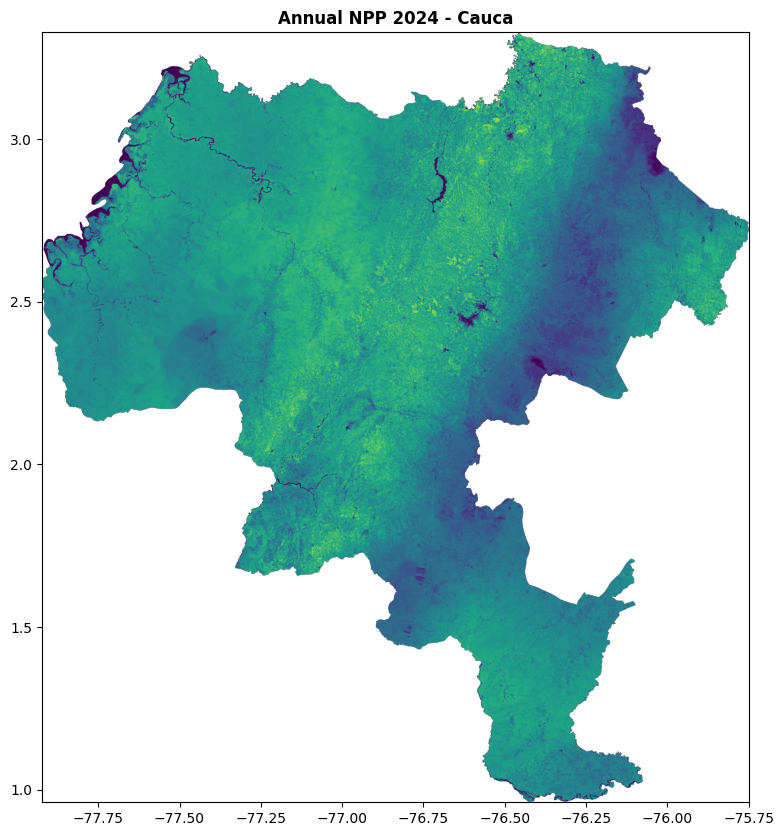

In [ ]:
with rio.open(anual_NPP) as npp:                        # Open the raster file
    fig, ax = plt.subplots(figsize=(10, 10))                # Create a matplotlib figure and axis object with a specified size
    show(npp, ax=ax, title='Annual NPP 2024 - Cauca')                 # Use rasterio's show function to display the raster data on the axes
    plt.show()                                              # Display the plot

To add more elements to the map you can adapt the script below. Try to change the colors used for the map (change the 'cmap' variable). For more information check [here](https://www.analyticsvidhya.com/blog/2020/09/colormaps-matplotlib/)



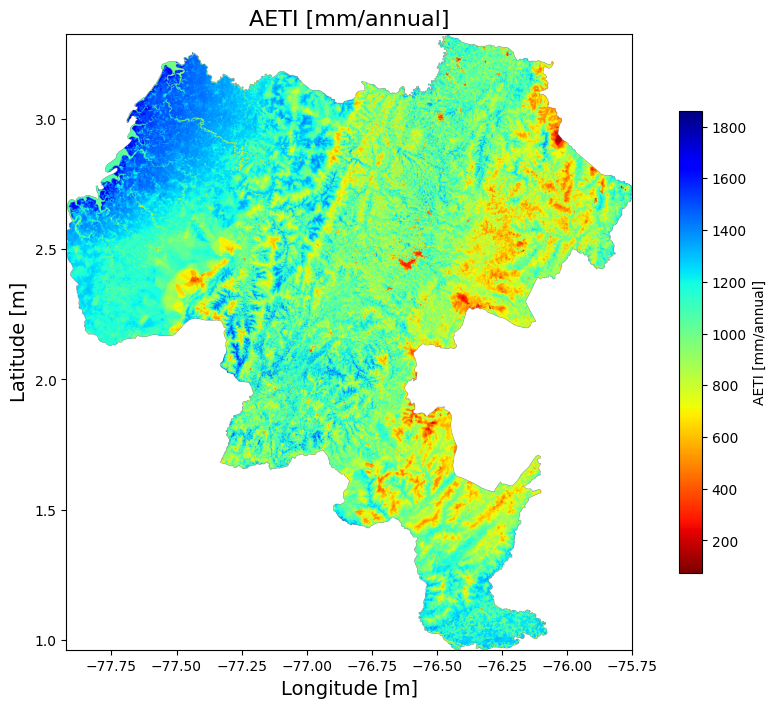

In [ ]:
anual = rio.open(anual_AETI)
spatial_extent = (anual.bounds.left, anual.bounds.right, anual.bounds.bottom, anual.bounds.top)

# Read the first band
data = anual.read(1)

# Plotting
plt.figure(figsize=(12, 8))
plt.imshow(data, cmap='jet_r', vmin=np.nanmin(data), vmax=np.nanmax(data), extent=spatial_extent)
plt.colorbar(shrink=0.75, label='AETI [mm/annual]')
plt.xlabel('Longitude [m]', fontsize=14)
plt.ylabel('Latitude [m]', fontsize=14)
plt.title('AETI [mm/annual]', fontsize=16)
plt.show()

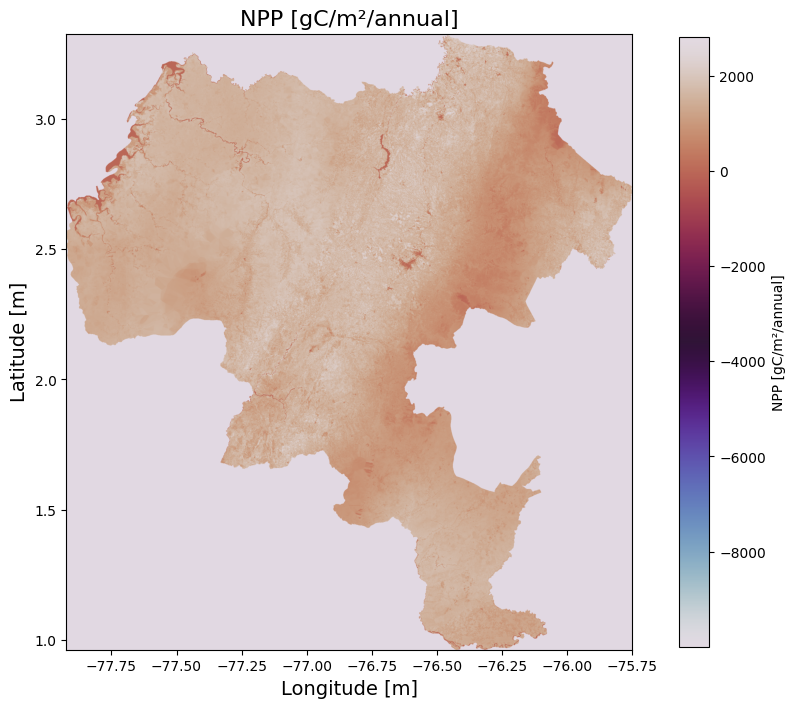

In [29]:
npp = rio.open(anual_NPP)
spatial_extent = (npp.bounds.left, npp.bounds.right, npp.bounds.bottom, npp.bounds.top)

# Read the first band
data = npp.read(1)

# Plotting
plt.figure(figsize=(12, 8))
plt.imshow(data, cmap='twilight', vmin=np.nanmin(data), vmax=np.nanmax(data), extent=spatial_extent)
plt.colorbar(shrink=0.99, label='NPP [gC/m²/annual]')
plt.xlabel('Longitude [m]', fontsize=14)
plt.ylabel('Latitude [m]', fontsize=14)
plt.title('NPP [gC/m²/annual]', fontsize=16)
plt.show()



---



## **Step 3 - Calculate annual statistics AETI & NPP for each municipality**

Upload and read the area of interest. In this case the Municipios_cauca.shp

**NOTE:**

The file for the farms in this script is a .shp file. Create a .shp file from the geojson file in QGIS first. Dont forget to upload all dependencies in the same folder!



In [ ]:
shapefile_path = '/content/drive/MyDrive/Data/Cauca/Municipios_cauca.shp'

,DPTOMPIO,DPTO_CCDGO,MPIO_CCDGO,MPIO_CNMBR,MPIO_CCNCT,geometry
0,19001,19,001,POPAYÁN,19001,"POLYGON Z ((-76.74201 2.57271 0, -76.74079 2.5..."
1,19022,19,022,ALMAGUER,19022,"POLYGON Z ((-76.8406 2.00018 0, -76.83969 1.99..."
2,19050,19,050,ARGELIA,19050,"POLYGON Z ((-77.204 2.40811 0, -77.20367 2.407..."
3,19075,19,075,BALBOA,19075,"POLYGON Z ((-77.17229 2.19755 0, -77.17088 2.1..."
4,19100,19,100,BOLÍVAR,19100,"POLYGON Z ((-76.93024 2.11098 0, -76.92997 2.1..."
5,19110,19,110,BUENOS AIRES,19110,"POLYGON Z ((-76.74625 3.13495 0, -76.74413 3.1..."
6,19130,19,130,CAJIBÍO,19130,"POLYGON Z ((-76.76346 2.74178 0, -76.76082 2.7..."
7,19137,19,137,CALDONO,19137,"POLYGON Z ((-76.37904 2.93241 0, -76.37876 2.9..."
8,19142,19,142,CALOTO,19142,"POLYGON Z ((-76.42537 3.20793 0, -76.42534 3.2..."
9,19212,19,212,CORINTO,19212,"POLYGON Z ((-76.28289 3.22871 0, -76.28278 3.2..."


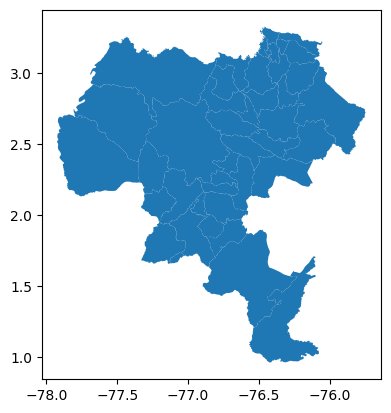

In [ ]:
gdf = gpd.read_file(shapefile_path)
# Plotting the fields
gdf.plot()
gdf

Get the shape and the annual mean AETI & NPP projections

In [ ]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
import rasterio

# Convert THE SHAPE CRS to EPSG:32618 (WGS84-18N) if necessary
if gdf.crs.to_epsg() != 32618:
    gdf = gdf.to_crs(epsg=32618)

# Reproject anual_AETI & anual_NPP to EPSG:32618 (WGS84-18N) Assuming anual_AETI and anual_NPP are file paths to raster data
with rasterio.open(anual_AETI) as src:
    anual_AETI = src.read(1)
    anual_AETI_meta = src.meta.copy()
    anual_AETI_meta['crs'] = 'epsg:32618'

with rasterio.open(anual_NPP) as src:
    anual_NPP = src.read(1)
    anual_NPP_meta = src.meta.copy()
    anual_NPP_meta['crs'] = 'epsg:32618'


In [ ]:
from rasterstats import zonal_stats
import pandas as pd
import numpy as np

# filter out empty or null geometries
gdf = gdf[~(gdf['geometry'].is_empty | gdf['geometry'].isna())]

# Calculate zonal statistics for mean
gdf["mean_NPP"] = pd.DataFrame(
            zonal_stats(
                vectors=gdf.geometry,
                raster=anual_NPP,
                affine=anual_NPP_meta['transform'], # Pass the affine transform
                nodata=np.nan,
                all_touched=False,
                stats=['mean']
            )
        )["mean"]
gdf

MemoryError: Unable to allocate 9.36 PiB for an array with shape (29661240, 44395806) and data type float64

We want to get the area for each of these farms and add this to the DataFrame.


In [ ]:
# Calculate area of each polygon in square meters
gdf['Area_sqm'] = gdf.area

# Initialize results DataFrame
gdf = gdf.copy()
gdf

,DPTOMPIO,DPTO_CCDGO,MPIO_CCDGO,MPIO_CNMBR,MPIO_CCNCT,geometry,Area_sqm
0,19001,19,001,POPAYÁN,19001,"POLYGON Z ((306321.705 284496.417 0, 306458.07...",4.828780e+08
1,19022,19,022,ALMAGUER,19022,"POLYGON Z ((295275.609 221195.629 0, 295376.59...",2.445984e+08
2,19050,19,050,ARGELIA,19050,"POLYGON Z ((254904.679 266368.743 0, 254941.16...",6.762864e+08
3,19075,19,075,BALBOA,19075,"POLYGON Z ((258396.614 243072.224 0, 258553.66...",4.118374e+08
4,19100,19,100,BOLÍVAR,19100,"POLYGON Z ((285316.643 233461.181 0, 285346.93...",7.869490e+08
5,19110,19,110,BUENOS AIRES,19110,"POLYGON Z ((305945.254 346671.893 0, 306181.05...",3.745858e+08
6,19130,19,130,CAJIBÍO,19130,"POLYGON Z ((303963.683 303195.857 0, 304257.06...",5.501494e+08
7,19137,19,137,CALDONO,19137,"POLYGON Z ((346732.445 324216.783 0, 346762.87...",3.471172e+08
8,19142,19,142,CALOTO,19142,"POLYGON Z ((341622.082 354686.376 0, 341625.56...",2.734608e+08
9,19212,19,212,CORINTO,19212,"POLYGON Z ((357459.449 356963.568 0, 357472.16...",2.894317e+08


<div class="alert alert-success">

**Exercise 1**

1. Which field (note Field ID) has the highest mean seasonal AETI and what is the amount in mm/season (round to integer - no decimal place)?

Hegeiliga_Median (3.30) (ID 1213)  **868** mm/season

2. In which **tertiary unit** is the largest field located and what is the area in ha (with one decimal)?

**Eltukl10** area **4.3**

3. The tertiary unit called FakiMusa6 has **26**  farms

<details>
  <summary>HINT</summary>

* Consider sorting the DataFrame
</details>
    
Note down the answers, you need them for the MOOC quiz!!

</div>

Why do the farms in BahiEddin21 have NaN values for the seasonal AETI?

<details>
  <summary>Answer</summary>

* There is no WaPOR data for this tertiary unit, so it didnt calculate seasonal AETI
</details>
    
</div>

In [ ]:
gdf.sort_values(by='mean_AETI', ascending=False)

KeyError: 'mean_AETI'

In [ ]:
gdf.sort_values(by='Area_sqm', ascending=False)

,id,yield,layer,path,geometry,Area_sqm,mean_AETI
104,1325,1.32,Eltukl10,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"POLYGON ((529391.085 1579648.519, 529576.712 1...",42953.284840,578.995960
190,1201,2.38,Hegeiliga_Median,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"POLYGON ((528844.677 1579336.659, 528939.401 1...",35746.163333,751.754167
30,3306,1.88,BahiEddin21,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"POLYGON ((516272.923 1584057.637, 516302.403 1...",34177.472511,NaN
211,1222,1.98,Hegeiliga_Median,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"POLYGON ((528069.161 1580109.373, 528153.308 1...",32143.973965,801.458730
191,1202,1.85,Hegeiliga_Median,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"POLYGON ((528760.532 1579415.47, 528842.565 15...",31148.721623,760.436842
...,...,...,...,...,...,...,...
82,1303,1.72,Eltukl10,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"POLYGON ((530288.025 1578758.294, 530471.965 1...",7257.989521,647.133333
193,1204,2.11,Hegeiliga_Median,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"POLYGON ((528697.099 1579481.714, 528716.126 1...",7121.860726,666.384211
113,2108,1.81,FakiMusa1,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"POLYGON ((522545.939 1581531.292, 522737.09 15...",6931.766052,825.710526
140,2205,2.38,FakiMusa6,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"POLYGON ((523932.536 1582591.013, 523952.406 1...",6912.061450,541.810417


In [ ]:
FakiMusa6 = gdf[gdf['layer'] == 'FakiMusa6']
length = len(FakiMusa6)
print(length)

26


We now want to get the timeseries statistics

**NOTE** Upload the WaPOR AETI dekadal data which you also used in Notebook 02. Dont forget to unzip the file!

In [ ]:
#upload .zipfile
uploaded = files.upload()

#unzip file
!unzip '/content/data.zip' -d '/content/'

Saving data.zip to data.zip
Archive:  /content/data.zip
   creating: /content/content/output/
   creating: /content/content/output/L3-AETI-D/
  inflating: /content/content/output/L3-AETI-D/Wad_Helal.GEZ_L3-AETI-D_NONE_dekad_converted_2023-01-11.tif  
  inflating: /content/content/output/L3-AETI-D/Wad_Helal.GEZ_L3-AETI-D_NONE_dekad_converted_2022-11-01.tif  
  inflating: /content/content/output/L3-AETI-D/Wad_Helal.GEZ_L3-AETI-D_NONE_dekad_converted_2023-03-21.tif  
  inflating: /content/content/output/L3-AETI-D/Wad_Helal.GEZ_L3-AETI-D_NONE_dekad_converted_2022-11-11.tif  
  inflating: /content/content/output/L3-AETI-D/Wad_Helal.GEZ_L3-AETI-D_NONE_dekad_converted_2023-04-21.tif  
  inflating: /content/content/output/L3-AETI-D/Wad_Helal.GEZ_L3-AETI-D_NONE_dekad_converted_2023-04-11.tif  
  inflating: /content/content/output/L3-AETI-D/Wad_Helal.GEZ_L3-AETI-D_NONE_dekad_converted_2023-02-21.tif  
  inflating: /content/content/output/L3-AETI-D/Wad_Helal.GEZ_L3-AETI-D_NONE_dekad_converted_202

In [ ]:
shapefile_path = '/content/WH_Fields/WH_Fields.shp'
folder_path = '/content/content/output/L3-AETI-D'

In [ ]:
def extract_identifier_from_filename(filename):   ## make sure to identify which part of the file name has date
    parts = filename.split('_')
    date_part = parts[6]
    return date_part.rstrip('.tif')

# Convert CRS to EPSG:32636 if necessary
if gdf.crs != 'epsg:32636':
    gdf = gdf.to_crs(epsg=32636)

# Calculate area of each polygon in square meters
gdf['Area_sqm'] = gdf.area

# Initialize results DataFrame
results_gdf = gdf.copy()

# Find all TIFF files in the folder
tif_files = glob.glob(os.path.join(folder_path, "*.tif"))
print(f"Found {len(tif_files)} TIFF files to process.")

# Process each TIFF file
for tif_file in tif_files:
    # Extract identifier from filename
    identifier = extract_identifier_from_filename(os.path.basename(tif_file))

    # Calculate zonal statistics for mean
    stats = zonal_stats(gdf, tif_file, stats="mean", nodata=-9999)  # Assuming -9999 as NoData value; adjust as necessary

    # Extract mean values and assign to new column in DataFrame
    means = [stat['mean'] if stat else None for stat in stats]
    results_gdf[identifier] = means

# Remove the geometry column from the results DataFrame for easier data handling/viewing
results_df = results_gdf.drop(columns=['geometry'])

# Now the DataFrame 'results_df' holds the results without the geometry column and includes area calculations
print("Mean zonal statistics by date/identifier are stored in the DataFrame, including area calculations.")


Found 21 TIFF files to process.
Mean zonal statistics by date/identifier are stored in the DataFrame, including area calculations.


In [ ]:
results_df

,id,yield,layer,path,mean_AETI,Area_sqm,2023-01-11,2022-11-01,2023-03-21,2022-11-11,...,2022-10-01,2023-04-01,2023-01-21,2023-01-01,2022-11-21,2022-12-11,2023-03-01,2022-10-11,2023-02-11,2022-12-21
0,3201,3.31,BahiEddin11,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,719.130769,15709.611935,54.256410,8.820513,44.338462,7.871795,...,12.102564,19.923077,79.115385,35.846154,8.051282,13.307692,74.461538,11.564103,83.205128,21.548718
1,3202,3.10,BahiEddin11,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,775.375676,14110.138587,54.135135,7.432432,57.645946,7.135135,...,9.000000,26.729730,80.864865,34.702703,7.864865,12.108108,86.648649,8.648649,90.594595,20.513514
2,3203,2.32,BahiEddin11,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,796.317647,14151.018939,62.617647,7.029412,49.305882,7.058824,...,8.235294,22.176471,87.708824,46.117647,8.058824,17.617647,82.676471,7.470588,91.705882,31.091176
3,3204,3.30,BahiEddin11,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,784.365000,7985.774205,55.400000,7.000000,57.475000,7.000000,...,7.900000,25.500000,82.940000,35.550000,8.000000,12.050000,88.750000,7.250000,93.000000,20.900000
4,3205,3.32,BahiEddin11,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,764.680000,8141.727369,51.900000,7.200000,57.475000,7.000000,...,7.950000,27.250000,79.915000,32.350000,8.000000,10.950000,87.100000,7.400000,90.550000,18.645000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,1220,3.17,Hegeiliga_Median,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,774.369136,8197.931434,61.555556,5.000000,52.188889,6.388889,...,6.000000,27.222222,85.127778,45.055556,8.277778,18.722222,81.777778,5.888889,88.888889,31.716667
210,1221,3.17,Hegeiliga_Median,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,786.183333,8092.891983,59.894737,5.157895,51.757895,6.526316,...,6.368421,26.473684,84.236842,43.157895,8.315789,17.105263,81.789474,6.157895,88.473684,29.294737
211,1222,1.98,Hegeiliga_Median,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,801.458730,32143.973965,60.938272,5.407407,49.567901,6.432099,...,6.901235,27.419753,81.128395,48.098765,8.802469,23.777778,75.580247,6.123457,81.358025,37.359259
212,1223,2.64,Hegeiliga_Median,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,NaN,7392.372200,59.388889,5.388889,52.311111,6.388889,...,7.111111,25.055556,82.805556,44.388889,9.111111,20.000000,82.555556,6.722222,87.833333,31.411111



You can interrogate the results using the Panda functions introduced in [Notebook 01 Introduction to Pandas and Geopandas](https://github.com/wateraccounting/WaPORMOOC/blob/main/3_Python_for_WaPOR/N01_Intro_Pandas_and_Geopandas.ipynb)

For example to find the max, min and mean of the seasonal AETI you can run the following script:

**HINT** Change the attribute name to the column you want to obtain the maximum value for


In [ ]:
results_df['mean_AETI'].max(), results_df['mean_AETI'].min(), results_df['mean_AETI'].mean()

(867.56, 428.255, np.float64(688.2703526495965))

An alternative way to do this is using the following function:

```python
    df.iloc[:,1:] # Selects the column of the dataframe starting from the second column
    .agg(['min', 'max', 'mean']) # aggregate function to calculate the min, max and mean of the selected dataframe columns
    .round() # function to round the values of the columns
    .astype(int) # to change the data type of the columns to integer

```

In [ ]:
# applying the above function to get minimum, maximum and mean of the AETI and the area
mm = results_df.iloc[:,4].agg(['min', 'max', 'mean']).round().astype(int)
mm

,mean_AETI
min,428
max,868
mean,688


Saving the dataframes computed above to .csv and download them to local folder:

In [ ]:
# for dataframe df
file_name = f'AETI_and_Area_per_farm_Wad_Helal.csv'
results_df.to_csv(file_name)

#download the csv file
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Step 4: Calculate zonal statistics for tertiary unit**:

>Do the zonal statistics for tertiary unit **`'FakiMusa6`** and get the minimum, maximum and mean of the seasonal average AETI and the area of each farm.

>Note down the values (rounded to the integer values), you will need them for the MOOC quiz.


<details>
  <summary>HINT</summary>

>Select the field **`'FakiMusa6'`** from the GeoDataFrame and run the last three cells.

</details>
    


As you can see from the DataFrame there are different categories in the 'layer' column, these represent the different tertiary units in the Wad Helal irrigation block. You can get the name of the tertiary units using the following code:

In [ ]:
# get the name of the fields
np.unique(results_df['layer'])

array(['BahiEddin11', 'BahiEddin21', 'BahiEddin3', 'Eltukl10',
       'FakiMusa1', 'FakiMusa6', 'FakiMusa9', 'Hegeiliga_Median'],
      dtype=object)

We can visualise the map of the farms with a differentiation between the different tertiary units (in the DataFrame, each tertiary unit has a different name in the 'layer' column).


<ipython-input-62-0b5486285d5a>:16: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(title='Tertiary Unit')
<ipython-input-62-0b5486285d5a>:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Tertiary Unit')


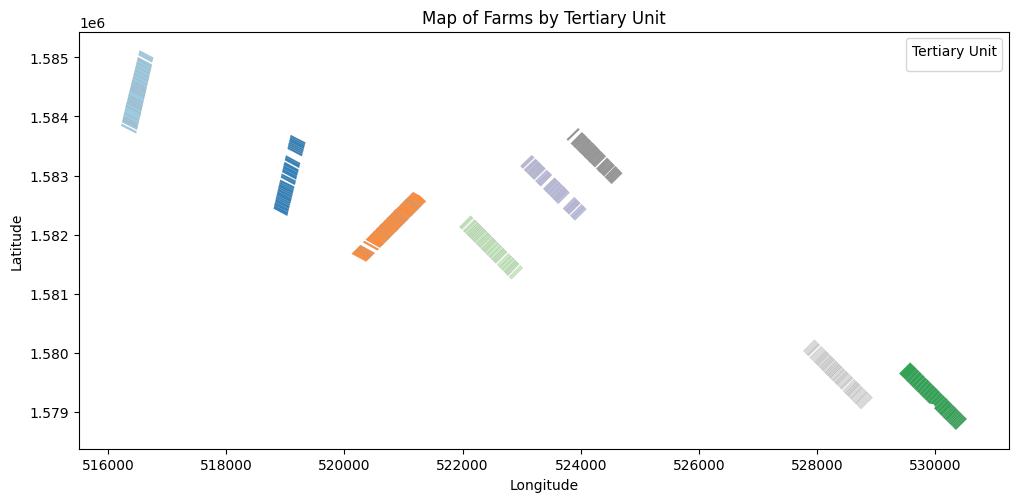

In [ ]:
# Prepare the figure and axis
fig, ax = plt.subplots(figsize=(12, 12))  # Adjust the figure size as necessary
gdf.boundary.plot(ax=ax, linewidth=0.1, color='gray')  # Draw boundaries with gray lines

# Generate a colormap for the unique layers
layers = gdf['layer'].unique()
colors = plt.cm.tab20c(np.linspace(0, 1, len(layers)))  # Choosing a color map and generating colors
color_dict = dict(zip(layers, colors))  # Create a dictionary to map layers to colors

# Plot each layer with a different color
for layer in layers:
    subset = gdf[gdf['layer'] == layer]
    subset.plot(ax=ax, label=layer, color=color_dict[layer])

# Add a legend to the plot with a title
ax.legend(title='Tertiary Unit')

# Set titles and labels
plt.title('Map of Farms by Tertiary Unit')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()


We have information about several farms within each tertiary unit. We want to filter all the farms from one tertiary unit. We will use the following code to find all farms within the **`'FakiMusa6'`** unit as an example:

In [ ]:
# Select Polygons in FakiMusa6 field

Faki_Musa_farms = results_df[results_df['layer'] == 'FakiMusa6']
Faki_Musa_farms

,id,yield,layer,path,mean_AETI,Area_sqm,2023-01-11,2022-11-01,2023-03-21,2022-11-11,...,2022-10-01,2023-04-01,2023-01-21,2023-01-01,2022-11-21,2022-12-11,2023-03-01,2022-10-11,2023-02-11,2022-12-21
136,2201,2.25,FakiMusa6,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,732.533333,15209.413007,52.421053,6.921053,36.589474,6.421053,...,17.789474,20.605263,69.386842,40.631579,7.578947,17.947368,57.210526,13.052632,63.157895,29.352632
137,2202,2.60,FakiMusa6,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,668.563158,15918.415546,53.487179,7.794872,45.551282,6.333333,...,15.564103,19.538462,78.974359,36.692308,7.205128,13.153846,77.589744,12.589744,84.871795,22.705128
138,2203,1.98,FakiMusa6,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,660.448148,7857.217073,52.157895,8.263158,37.863158,6.210526,...,15.526316,17.736842,74.915789,36.210526,7.105263,13.157895,65.842105,12.526316,74.842105,22.578947
139,2204,1.81,FakiMusa6,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,664.458333,8824.490907,53.074074,7.777778,34.711111,6.296296,...,16.481481,16.777778,74.881481,37.888889,7.222222,14.185185,62.888889,13.037037,73.666667,24.322222
140,2205,2.38,FakiMusa6,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,541.810417,6912.061450,47.916667,8.250000,39.875000,6.666667,...,17.250000,19.500000,71.591667,32.833333,7.666667,12.750000,67.083333,13.250000,74.333333,20.716667
141,2206,2.25,FakiMusa6,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,665.782927,16365.874922,32.020833,9.166667,34.100000,7.833333,...,18.479167,16.833333,49.660417,21.291667,7.604167,10.270833,58.416667,14.291667,57.666667,14.804167
142,2207,1.69,FakiMusa6,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,711.828571,16014.788832,43.804878,8.926829,44.268293,7.780488,...,15.024390,22.073171,67.878049,27.975610,7.536585,10.292683,71.268293,12.634146,75.414634,16.821951
143,2208,2.38,FakiMusa6,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,713.284211,8348.461817,51.190476,7.476190,46.985714,6.666667,...,11.523810,23.190476,77.052381,34.000000,7.285714,11.047619,75.380952,10.190476,82.285714,20.166667
144,2209,2.64,FakiMusa6,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,662.584211,8690.251614,49.789474,8.421053,48.515789,6.947368,...,14.421053,24.368421,74.047368,34.052632,7.105263,11.894737,75.157895,12.263158,79.315789,20.957895
145,2210,2.18,FakiMusa6,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,701.571053,15718.156476,40.894737,8.421053,47.850000,7.052632,...,14.789474,21.578947,65.189474,25.526316,7.078947,9.447368,75.736842,12.263158,75.684211,15.023684


<div class="alert alert-success">

**Excercise 2**

Can you find out how many fields within this tertiary unit are listed in this DataFrame?

Note down this answer, you need it in the MOOC quiz!

HINT: check out **Exercise 3** of [Notebook 01 Introduction to Pandas and Geopandas](https://github.com/wateraccounting/WaPORMOOC/blob/main/3_Python_for_WaPOR/N01_Intro_Pandas_and_Geopandas.ipynb)


</div>

In [ ]:
# extract number of farms in FakiMusa6 tertiary unit
length = len(Faki_Musa_farms)
print(length)

26




---



## **Step 5 Visualising dekadal AETI time series**
If you want to visualise the timeseries of dekadal AETI for each farm, you can run the following three cells, starting with reading the .csv file you created in the previous steps.

Investigate the DataFrame, now there are several attributes we do not need for the analyses, so we exclude these columns (uncheck the second line, run the Cell and investigate the DataFrame).

The next Code Cell transposes the data, which we need to be able to plot the data.


In [ ]:
df = pd.read_csv(r'AETI_and_Area_per_farm_Wad_Helal.csv',index_col=1)
df = df.iloc[:, 6:] #exclude other columns, keep only time-series data
df

,2023-01-11,2022-11-01,2023-03-21,2022-11-11,2023-04-21,2023-04-11,2023-02-21,2023-02-01,2022-12-01,2022-10-21,...,2022-10-01,2023-04-01,2023-01-21,2023-01-01,2022-11-21,2022-12-11,2023-03-01,2022-10-11,2023-02-11,2022-12-21
id,,,,,,,,,,,,,,,,,,,,,
3201,54.256410,8.820513,44.338462,7.871795,7.000000,9.589744,66.420513,82.871795,8.051282,10.041026,...,12.102564,19.923077,79.115385,35.846154,8.051282,13.307692,74.461538,11.564103,83.205128,21.548718
3202,54.135135,7.432432,57.645946,7.135135,8.054054,12.027027,74.356757,87.297297,7.216216,7.670270,...,9.000000,26.729730,80.864865,34.702703,7.864865,12.108108,86.648649,8.648649,90.594595,20.513514
3203,62.617647,7.029412,49.305882,7.058824,7.852941,10.705882,72.988235,91.352941,9.676471,6.664706,...,8.235294,22.176471,87.708824,46.117647,8.058824,17.617647,82.676471,7.470588,91.705882,31.091176
3204,55.400000,7.000000,57.475000,7.000000,8.350000,11.400000,76.440000,89.650000,7.250000,6.710000,...,7.900000,25.500000,82.940000,35.550000,8.000000,12.050000,88.750000,7.250000,93.000000,20.900000
3205,51.900000,7.200000,57.475000,7.000000,8.350000,12.550000,74.880000,86.650000,7.050000,6.765000,...,7.950000,27.250000,79.915000,32.350000,8.000000,10.950000,87.100000,7.400000,90.550000,18.645000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220,61.555556,5.000000,52.188889,6.388889,8.888889,14.388889,71.600000,88.166667,10.111111,4.583333,...,6.000000,27.222222,85.127778,45.055556,8.277778,18.722222,81.777778,5.888889,88.888889,31.716667
1221,59.894737,5.157895,51.757895,6.526316,8.473684,14.105263,71.578947,87.105263,9.473684,5.036842,...,6.368421,26.473684,84.236842,43.157895,8.315789,17.105263,81.789474,6.157895,88.473684,29.294737
1222,60.938272,5.407407,49.567901,6.432099,10.407407,15.691358,66.143210,81.530864,13.370370,4.861728,...,6.901235,27.419753,81.128395,48.098765,8.802469,23.777778,75.580247,6.123457,81.358025,37.359259


In [ ]:
df = df.transpose() #transpose dataframe
df

id,3201,3202,3203,3204,3205,3206,3207,3208,3209,3210,...,1215,1216,1217,1218,1219,1220,1221,1222,1223,1224
2023-01-11,54.256410,54.135135,62.617647,55.400,51.900,47.200000,41.655172,34.894737,52.333333,57.444444,...,69.400,65.447368,69.105263,57.952381,62.400000,61.555556,59.894737,60.938272,59.388889,67.761905
2022-11-01,8.820513,7.432432,7.029412,7.000,7.200,8.288889,8.206897,7.157895,6.416667,6.777778,...,5.280,6.473684,5.315789,5.857143,5.888889,5.000000,5.157895,5.407407,5.388889,5.650794
2023-03-21,44.338462,57.645946,49.305882,57.475,57.475,36.960000,48.779310,70.515789,61.691667,48.888889,...,57.288,51.873684,49.905263,45.990476,43.975556,52.188889,51.757895,49.567901,52.311111,46.636508
2022-11-11,7.871795,7.135135,7.058824,7.000,7.000,7.155556,7.517241,7.578947,7.027778,6.722222,...,6.040,6.421053,6.210526,6.904762,6.888889,6.388889,6.526316,6.432099,6.388889,6.380952
2023-04-21,7.000000,8.054054,7.852941,8.350,8.350,8.155556,8.551724,11.842105,9.027778,8.166667,...,8.680,9.000000,9.157895,10.619048,7.844444,8.888889,8.473684,10.407407,8.833333,10.095238
2023-04-11,9.589744,12.027027,10.705882,11.400,12.550,10.622222,12.034483,20.684211,13.916667,11.500000,...,14.040,13.736842,13.842105,14.666667,11.066667,14.388889,14.105263,15.691358,13.000000,13.285714
2023-02-21,66.420513,74.356757,72.988235,76.440,74.880,58.240000,62.537931,66.652632,74.933333,69.955556,...,78.496,75.368421,73.978947,68.800000,70.275556,71.600000,71.578947,66.143210,71.911111,68.279365
2023-02-01,82.871795,87.297297,91.352941,89.650,86.650,71.022222,68.724138,64.631579,85.888889,87.277778,...,94.720,93.157895,92.842105,86.000000,88.400000,88.166667,87.105263,81.530864,85.944444,88.444444
2022-12-01,8.051282,7.216216,9.676471,7.250,7.050,7.755556,7.586207,7.947368,7.277778,7.944444,...,11.000,10.289474,11.157895,9.428571,10.111111,10.111111,9.473684,13.370370,11.388889,13.301587
2022-10-21,10.041026,7.670270,6.664706,6.710,6.765,9.093333,8.610345,6.947368,6.172222,6.783333,...,4.972,6.571053,4.747368,4.871429,5.280000,4.583333,5.036842,4.861728,5.133333,5.604762



# i) Create timeseries graph



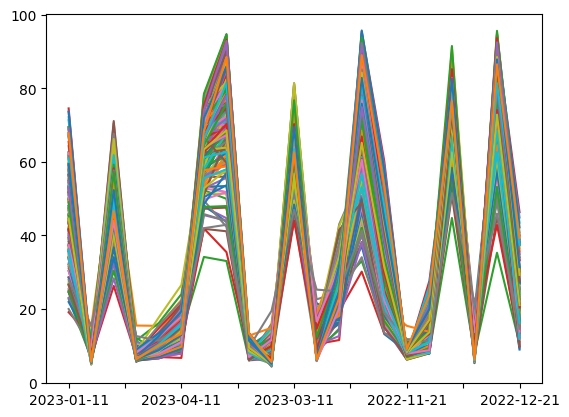

In [ ]:
df.plot(legend=False);

What is wrong with this graph?

<details>
  <summary>Answer</summary>

* Dates are not in order

NOTE:
* The following code recognises the first column as date type and then rerunning the script with present the data in the right order
* Once you have updated the DataFrame and you rerun earlier scripts, these will now use the updated DataFrame

</details>
    
</div>



In [ ]:
# convert id in string format to datetime
df.index= pd.to_datetime(df.index, format='%Y-%m-%d')
df

id,3201,3202,3203,3204,3205,3206,3207,3208,3209,3210,...,1215,1216,1217,1218,1219,1220,1221,1222,1223,1224
2023-01-11,54.256410,54.135135,62.617647,55.400,51.900,47.200000,41.655172,34.894737,52.333333,57.444444,...,69.400,65.447368,69.105263,57.952381,62.400000,61.555556,59.894737,60.938272,59.388889,67.761905
2022-11-01,8.820513,7.432432,7.029412,7.000,7.200,8.288889,8.206897,7.157895,6.416667,6.777778,...,5.280,6.473684,5.315789,5.857143,5.888889,5.000000,5.157895,5.407407,5.388889,5.650794
2023-03-21,44.338462,57.645946,49.305882,57.475,57.475,36.960000,48.779310,70.515789,61.691667,48.888889,...,57.288,51.873684,49.905263,45.990476,43.975556,52.188889,51.757895,49.567901,52.311111,46.636508
2022-11-11,7.871795,7.135135,7.058824,7.000,7.000,7.155556,7.517241,7.578947,7.027778,6.722222,...,6.040,6.421053,6.210526,6.904762,6.888889,6.388889,6.526316,6.432099,6.388889,6.380952
2023-04-21,7.000000,8.054054,7.852941,8.350,8.350,8.155556,8.551724,11.842105,9.027778,8.166667,...,8.680,9.000000,9.157895,10.619048,7.844444,8.888889,8.473684,10.407407,8.833333,10.095238
2023-04-11,9.589744,12.027027,10.705882,11.400,12.550,10.622222,12.034483,20.684211,13.916667,11.500000,...,14.040,13.736842,13.842105,14.666667,11.066667,14.388889,14.105263,15.691358,13.000000,13.285714
2023-02-21,66.420513,74.356757,72.988235,76.440,74.880,58.240000,62.537931,66.652632,74.933333,69.955556,...,78.496,75.368421,73.978947,68.800000,70.275556,71.600000,71.578947,66.143210,71.911111,68.279365
2023-02-01,82.871795,87.297297,91.352941,89.650,86.650,71.022222,68.724138,64.631579,85.888889,87.277778,...,94.720,93.157895,92.842105,86.000000,88.400000,88.166667,87.105263,81.530864,85.944444,88.444444
2022-12-01,8.051282,7.216216,9.676471,7.250,7.050,7.755556,7.586207,7.947368,7.277778,7.944444,...,11.000,10.289474,11.157895,9.428571,10.111111,10.111111,9.473684,13.370370,11.388889,13.301587
2022-10-21,10.041026,7.670270,6.664706,6.710,6.765,9.093333,8.610345,6.947368,6.172222,6.783333,...,4.972,6.571053,4.747368,4.871429,5.280000,4.583333,5.036842,4.861728,5.133333,5.604762


For plotting one field you can use the following code:

<Axes: >

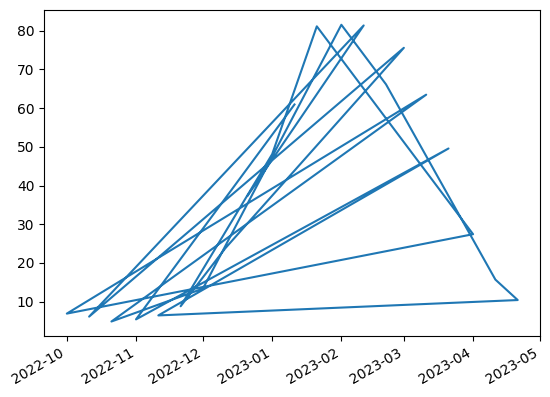

In [ ]:
df[1222].plot()

To style the graph you can add different elements.

Here we can see the default plot for this type of data.
A number of elements are missing, for example a title, axis labels and units... The following elements can be added/changed:

>The axis labels *ylabel*

>The plot title with *title*

>The line style

>The figure size with *figsize *

You can find a reference for the different options [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html)

The y-axis label is a not very clear, can you update it with the right information?  

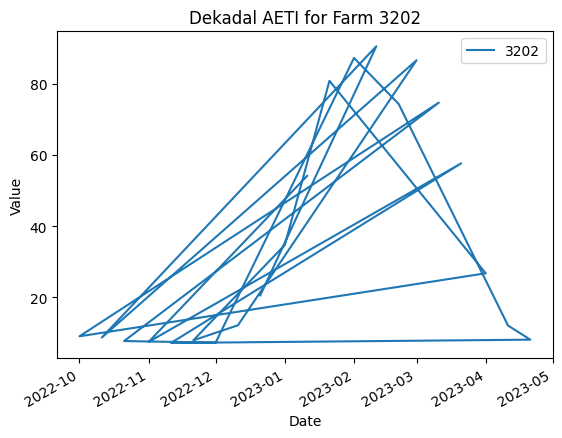

In [ ]:
df[3202].plot(legend=True, title='Dekadal AETI for Farm 3202')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

Can you create a plot with all the farms in one tertiary unit eg 'FakiMusa6'?

<details>
  <summary>HINT</summary>

* Create a DataFrame for only farms in 'FakiMusa6' tertiary unit
* Then create the plot

Can you add a legend?

</details>
    
</div>

Share your results in the discussion forum!


# ii) Create a scatterplot

You may also want to produce scatter plots, or xy plots to compare how the ET of two plots compares. You can do this by changing the style of your plot and defining the x and y variables as shown below.


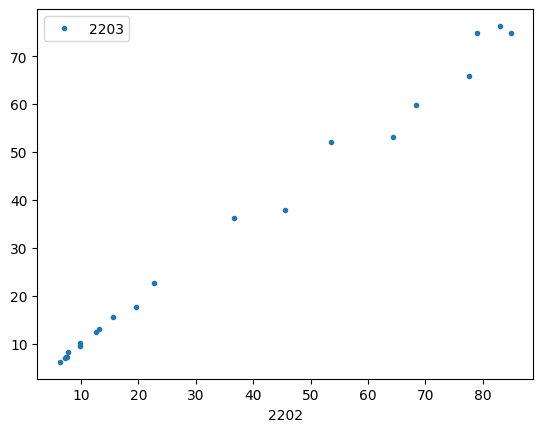

In [ ]:
df.plot(x=2202, y=2203, style='.');


This .plot() call will only work on a dataframe, so if you have data in arrays or lists or if you want to make certain kinds of plots and have better control over your figure you may need to use matplotlib instead.
To make a similar plot to that of the scatter above, we can use the scatter function from matplotlib.pyplot (imported as plt in cell 1):

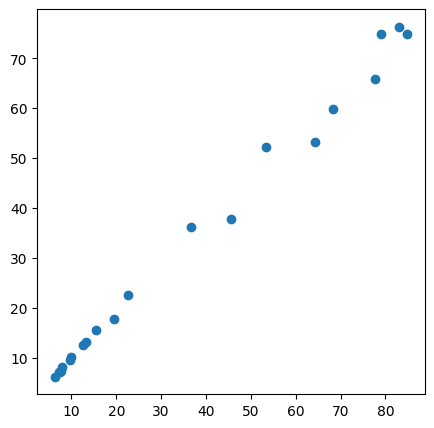

In [ ]:
plt.figure(figsize=[5, 5])
plt.scatter(df[2202],df[2203]);


For such a plot it makes sense for the x and y limits to be harmonizes, to add a grid and to add the 1:1 line, as well as our standards, the labels and a title. To do these things, it can be helpful to have a direct way to interact with the axes, for this we will start with defining a figure and axes



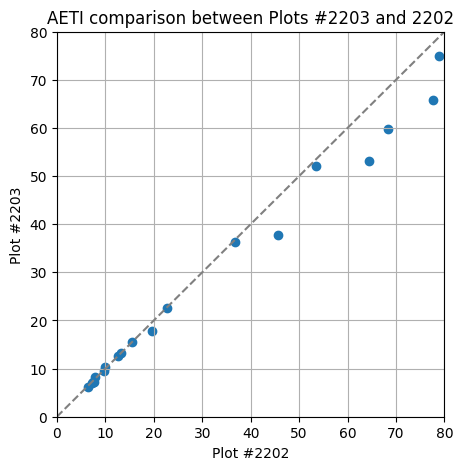

In [ ]:
fig, ax = plt.subplots(figsize=[5, 5])

ax.set_ylim([0,80]);
ax.set_xlim([0,80]);
ax.grid(True)

ax.plot([0,80],[0,80],color='grey', linestyle='--')
ax.scatter(df[2202],df[2203]);

ax.set_ylabel('Plot #2203')
ax.set_xlabel('Plot #2202')

plt.title('AETI comparison between Plots #2203 and 2202');

In [ ]:
# # if you want to delete a folder use the code below.
# !rm -rf /content/L3-AETI-D
# !rm -rf /content/tifs
# !rm -rf /content/L3-AETI-D.zip